# Proyecto 2 
### Curso : Inteligencia Artificial
### Profesor : Cristian López Del Alamo

#### Nombres y Apellidos de Integrantes:

##### Integrante 1: Fabrizio Jesús Vásquez Auqui
##### Integrante 2: Ignacio Rubio

### Librerías

In [287]:
import os
import numpy as np
import pandas as pd
import pywt


import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod
from skimage.io import imread, imshow

# Utilidades
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score, rand_score, adjusted_mutual_info_score, adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics.cluster import homogeneity_score
from scipy.stats import multivariate_normal
import glob

# Librarías de modelos usados
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KDTree

import random


In [169]:
path = "./data/CK+48/"

In [170]:
def printCluster(target, prediction):
    cluster_element = {}
    for i, element in zip(target, list(prediction)):
        if i not in cluster_element:
            cluster_element[i] =[element]
        else:
            if element not in cluster_element[i]:
                cluster_element[i].append(element)
    print(cluster_element)

#### Base de datos de Emociones



##### Función para obtener los vectores característicos y PCA

In [330]:
content = os.listdir(path)

def feature_vector(picture, cortes):
  LL = picture
  for i in range(cortes):
    LL, (LH, HL, HH) = pywt.dwt2(LL, 'haar')
     #LL = LL/255
  #return LL.flatten()
  return LL.flatten()

def transform(img,n_components_=0.9999999):
  #scalar = MinMaxScaler()
  #img_scaled = scalar.fit_transform(img)
  pca_model = PCA(n_components=n_components_)
  pca_model.fit(img)
  transform_img = pca_model.transform(img)
  #projection = img_pca.inverse_transform(tranform_img)
  #plt.imshow(projection, cmap='gray')
  #print(transform_img.shape)
  return transform_img

def imagen_feature_vector(image_path):
  picture = imread(image_path)
  # len of feature vector = dim_1(picture)*dim_2(picture) / 4^cortes
  # len_feature_vector = dim_n(picure)/ 4^cortes
  # reduction_feature_vector = transform(picture)
  img = feature_vector(picture,3)
  coefficients_matrix = np.stack(img)
  data = coefficients_matrix.reshape(coefficients_matrix.shape[0], -1)

  #print(data.shape)

  img_pca = transform(data)
  #converted_img = img_pca.fit_transform(img)
  return img_pca.flatten()

  
# 48 * 48
#len(imread('./data/CK+48/anger/S010_004_00000017.png'))
#transform(imread('./data/CK+48/anger/S010_004_00000017.png'))
#imagen_feature_vector('./data/CK+48/anger/S010_004_00000017.png')
len(imagen_feature_vector('./data/CK+48/anger/S010_004_00000017.png'))


36

La imagen ha sido redimensionada mediante la Transformada Wavelet Discreta, en el cual el numero de dimensiones de nuestro vector caracterisrico dependera del numero de cortes

In [331]:
imagen_feature_vector('./data/CK+48/anger/S010_004_00000017.png')

array([-546.19791667, -449.94791667,  368.67708333,  552.55208333,
       -214.82291667, -461.82291667, -554.07291667, -114.44791667,
        206.42708333,  196.30208333,  127.42708333, -578.57291667,
       -331.82291667, -289.19791667,  152.42708333, -115.07291667,
       -135.19791667, -368.32291667,  176.30208333,  458.80208333,
        524.17708333,  407.05208333,  364.05208333,  164.42708333,
       -480.44791667,  260.80208333,  116.05208333,   39.42708333,
         88.05208333, -491.82291667,  952.30208333,  161.30208333,
       -129.82291667, -242.44791667, -167.07291667,  354.55208333])

##### Función para cargar imágenes

In [332]:
# Cantidad de imagenes en cada carpeta
# anger:
# contempt: 
# disgust: 
# fear: 
# happy: 
# sadness:
# suprise: 

In [333]:
def feature_vector_load_images(folder):
  dicc = {}
  name_images = []
  feature_vector_val = []
  with os.scandir(path) as ficheros:
      for fichero in ficheros:
          if(fichero.name != ".DS_Store"):
            name_images.append(fichero.name)
            #dicc[fichero.name] = imagen_feature_vector(path+fichero.name)
            for name_image in os.scandir(fichero.path):
               #print(name_image.path,name_image.name)
               if(name_image.name not in dicc):
                dicc[name_image.path] = imagen_feature_vector(name_image.path)
                feature_vector_val.append(imagen_feature_vector(name_image.path))
                #print(imagen_feature_vector(name_image.path).shape)
                #dicc[name_image.path] = fichero.name

  return feature_vector_val

def complete(data):
  longitud_maxima = max(len(secuencia) for secuencia in data)
  # Realiza relleno (padding) para igualar la longitud de las secuencias
  datos_rellenados = []
  for secuencia in data:
      diferencia_longitud = longitud_maxima - len(secuencia)
      secuencia_rellenada = np.pad(secuencia, (0, diferencia_longitud), mode='constant')
      datos_rellenados.append(secuencia_rellenada)
  return np.array(datos_rellenados)

X = feature_vector_load_images(path) 
#complete_list_vectores_images = complete(list_vectores_images)
#images = np.concatenate(list_vectores_images) 
#type(images)
#X[0].shape


In [334]:
X = np.array(X)
X.shape

(981, 36)

### Contar y guardar la cantidad de imagenes por tipo

#### Análisis exploratorio de los datos

In [325]:
# Guardando informacion de los tipos de imagenes en un dataframe para analizar
#count_images = 1
#dicc_images = {}
#for i,j in images.items():
#   dicc_images[count_images]= j
#   count_images += 1

#df_types = pd.DataFrame(dicc_images.items(), columns=['id', 'type'])
#df_types.to_csv('./data/data.csv', index=False, header=True, sep=',')

# Leer datos del csv exportado previamente
df_types = pd.read_csv('./data/data.csv')
target = np.array(df_types['type']).T
# Porcentaje de imagenes por tipo


label_num = {"happy": 0, "contempt" : 1, "fear" : 2, "surprise" : 3, "sadness" : 4, "anger" : 5, "disgust" : 6}
#label_num = {"anger": 0, "contempt" : 1, "disgust" : 2, "fear" : 3, "happy" : 4, "sadness" : 5, "surprise" : 6}
y = list(df_types.iloc[:, 1])
labels_true = [label_num[e] for e in y]

(100 * df_types['type'].value_counts() / len(df_types['type'])).round(2)


surprise    25.38
happy       21.10
disgust     18.04
anger       13.76
sadness      8.56
fear         7.65
contempt     5.50
Name: type, dtype: float64

Text(0, 0.5, 'Cantidad de imagenes')

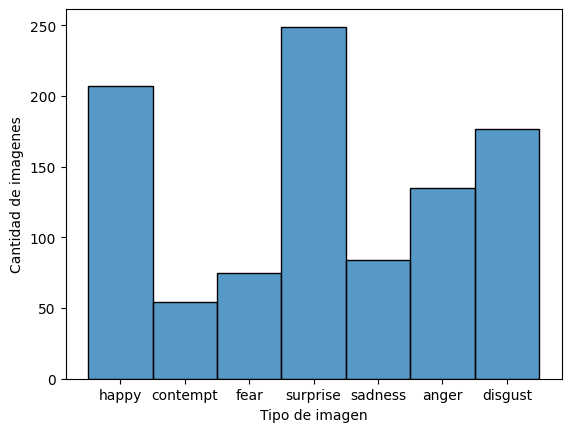

In [326]:
#df_types['type'].value_counts().plot(kind='bar',title='imagenes')
sns.histplot(data=df_types, x="type")
plt.xlabel('Tipo de imagen')
plt.ylabel('Cantidad de imagenes')

### Clase de Clustering

In [327]:
class Clustering(metaclass=ABCMeta):
    pass

#### Kmeans

In [328]:
class KMeansClustering(Clustering):
    def __init__(self,data, n_clusters=7,n_iter = 1000):
        self.data = data
        self.n_clusters = n_clusters
        self.n_iter = n_iter
        print("KMeansClustering: ",self.n_clusters)
        
    def init_centroide(self,data):
        centroides = data[np.random.choice(data.shape[0], self.n_clusters, replace=False),:]
        return centroides   
    
    def get_min_distance(self,data,centroide):
        index = []
        for row in data:
            index.append(np.argmin(euclidean_distances(centroide,[row])))
        return index
    
    def get_means(self,data,grupos,n):
        centroides = []
        for i in range(n):
            array = [data[j] for j, k in enumerate(grupos) if i == k]
            centroides.append(np.sum(array, axis = 0) / len(array))
        return centroides
    
    def kmean(self,):
        centroides = self.init_centroide(self.data) # Selecciona k centroides
        grupos = None
        for i in range(self.n_iter):
            grupos = self.get_min_distance(self.data, centroides)
            temp =  self.get_means(self.data, grupos, self.n_clusters)
            diff = np.array(centroides) - np.array(temp)
            centroides = temp
        return centroides, grupos



In [243]:
def get_score(labels_true, prediction_pca, X_pca):
    scores = {
        "PCA": np.array([silhouette_score(X_pca, prediction_pca),
        homogeneity_score(labels_true, prediction_pca), 
        rand_score(labels_true, prediction_pca),
        adjusted_rand_score(labels_true, prediction_pca), 
        adjusted_mutual_info_score(labels_true, prediction_pca)]), 
    }
    df = pd.DataFrame.from_dict(scores, orient = "index", columns=["Silhouette","Homogeneidad", "Rand", "Adjust Rand", "Adjust Mutual Information"])
    return df

In [244]:
kmeans_pca = KMeans(n_clusters=7, random_state= 42)
kmeans_pca.fit(X)
kmeans_model = KMeansClustering(X, n_clusters=7,n_iter = 1000)
centroides_pca, labels_impl = kmeans_model.kmean()
prediction_kmeans = kmeans_pca.predict(X)
print("PCA Kmeans sklearn")
printCluster(target, prediction_kmeans)
print("PCA Kmeans Implementado")
printCluster(target, labels_impl)


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeansClustering:  7
PCA Kmeans sklearn
{'happy': [3, 5, 6, 0, 4, 1, 2], 'contempt': [3, 2, 6, 0, 4], 'fear': [0, 4, 1, 6, 2, 3], 'surprise': [4, 0, 2, 3, 6, 5, 1], 'sadness': [4, 3, 2, 0, 5, 6, 1], 'anger': [1, 3, 6, 2, 0, 4], 'disgust': [0, 2, 6, 3, 5, 4, 1]}
PCA Kmeans Implementado
{'happy': [0, 2, 5, 4, 1, 6, 3], 'contempt': [0, 4, 3, 5, 6, 1], 'fear': [4, 1, 2, 5, 3, 0], 'surprise': [1, 6, 3, 0, 4, 5, 2], 'sadness': [1, 0, 3, 4, 2, 5, 6], 'anger': [2, 0, 5, 3, 4, 1, 6], 'disgust': [4, 3, 5, 0, 2, 1, 6]}


In [245]:
df = get_score(labels_true, labels_impl,X)
df

,Silhouette,Homogeneidad,Rand,Adjust Rand,Adjust Mutual Information
PCA,0.41596,0.052652,0.714664,0.021304,0.042807


In [246]:
df = get_score(labels_true, prediction_kmeans,X)
df

,Silhouette,Homogeneidad,Rand,Adjust Rand,Adjust Mutual Information
PCA,0.485092,0.047876,0.705157,0.010083,0.038354


In [247]:
for i in range(2,8):
    random.seed(10)
    kmeans_pca = KMeans(n_clusters=i, random_state= 42)
    kmeans_pca.fit(X)
    kmeans_model = KMeansClustering(X, n_clusters=i,n_iter = 1000)
    centroides_pca, labels_impl = kmeans_model.kmean()
    prediction_kmeans = kmeans_pca.predict(X)
    print("PCA Kmeans sklearn")
    printCluster(target, prediction_kmeans)
    print("PCA Kmeans Implementado")
    printCluster(target, labels_impl)
    print("IMPLEMENTADO\n",get_score(labels_true, labels_impl,X))
    print("LIBRERIA\n",get_score(labels_true, prediction_kmeans,X))

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeansClustering:  2
PCA Kmeans sklearn
{'happy': [0, 1], 'contempt': [0, 1], 'fear': [0, 1], 'surprise': [0, 1], 'sadness': [0, 1], 'anger': [1, 0], 'disgust': [0, 1]}
PCA Kmeans Implementado
{'happy': [1, 0], 'contempt': [1, 0], 'fear': [1, 0], 'surprise': [1, 0], 'sadness': [1, 0], 'anger': [0, 1], 'disgust': [1, 0]}
IMPLEMENTADO
      Silhouette  Homogeneidad      Rand  Adjust Rand  \
PCA    0.525843      0.005902  0.471015     0.001568   

     Adjust Mutual Information  
PCA                   0.006242  
LIBRERIA
      Silhouette  Homogeneidad      Rand  Adjust Rand  \
PCA    0.525843      0.005902  0.471015     0.001568   

     Adjust Mutual Information  
PCA                   0.006242  
KMeansClustering:  3


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


PCA Kmeans sklearn
{'happy': [0, 1, 2], 'contempt': [0, 2], 'fear': [0, 1, 2], 'surprise': [0, 2, 1], 'sadness': [0, 2, 1], 'anger': [1, 0, 2], 'disgust': [0, 2, 1]}
PCA Kmeans Implementado
{'happy': [1, 0, 2], 'contempt': [1, 2, 0], 'fear': [2, 1, 0], 'surprise': [1, 2, 0], 'sadness': [1, 0, 2], 'anger': [0, 1, 2], 'disgust': [2, 0, 1]}
IMPLEMENTADO
      Silhouette  Homogeneidad      Rand  Adjust Rand  \
PCA    0.414453      0.011625  0.595706     0.010572   

     Adjust Mutual Information  
PCA                   0.010486  
LIBRERIA
      Silhouette  Homogeneidad      Rand  Adjust Rand  \
PCA    0.585789      0.023171  0.510171     0.001598   

     Adjust Mutual Information  
PCA                   0.026745  


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeansClustering:  4
PCA Kmeans sklearn
{'happy': [3, 1, 2, 0], 'contempt': [3, 0, 2], 'fear': [0, 3, 1, 2], 'surprise': [3, 0, 2, 1], 'sadness': [3, 2, 0, 1], 'anger': [1, 3, 2, 0], 'disgust': [0, 2, 3, 1]}
PCA Kmeans Implementado
{'happy': [1, 3, 0, 2], 'contempt': [1, 3, 0, 2], 'fear': [0, 2, 3, 1], 'surprise': [2, 0, 3, 1], 'sadness': [2, 1, 3, 0], 'anger': [3, 1, 0, 2], 'disgust': [0, 3, 1, 2]}
IMPLEMENTADO
      Silhouette  Homogeneidad      Rand  Adjust Rand  \
PCA    0.351709      0.021777  0.659319     0.019135   

     Adjust Mutual Information  
PCA                   0.019273  
LIBRERIA
      Silhouette  Homogeneidad      Rand  Adjust Rand  \
PCA    0.489429      0.028894  0.634862     0.011567   

     Adjust Mutual Information  
PCA                   0.027992  
KMeansClustering:  5


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


PCA Kmeans sklearn
{'happy': [0, 4, 1, 3, 2], 'contempt': [0, 3, 1], 'fear': [3, 0, 2, 1], 'surprise': [0, 3, 1, 4, 2], 'sadness': [0, 1, 3, 4, 2], 'anger': [2, 0, 1, 3], 'disgust': [3, 1, 0, 4, 2]}
PCA Kmeans Implementado
{'happy': [2, 4, 0, 1, 3], 'contempt': [2, 0, 1, 3], 'fear': [1, 3, 4, 0, 2], 'surprise': [3, 1, 0, 2, 4], 'sadness': [3, 2, 0, 1, 4], 'anger': [4, 2, 0, 1, 3], 'disgust': [1, 0, 2, 4, 3]}
IMPLEMENTADO
      Silhouette  Homogeneidad      Rand  Adjust Rand  \
PCA     0.45376      0.034906  0.691046     0.015465   

     Adjust Mutual Information  
PCA                   0.030387  
LIBRERIA
      Silhouette  Homogeneidad      Rand  Adjust Rand  \
PCA    0.508766      0.036751  0.640658     0.004911   

     Adjust Mutual Information  
PCA                   0.034058  
KMeansClustering:  6


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


PCA Kmeans sklearn
{'happy': [0, 3, 5, 4, 1, 2], 'contempt': [0, 4, 2, 5], 'fear': [4, 0, 1, 5, 2], 'surprise': [0, 4, 2, 5, 3, 1], 'sadness': [0, 2, 4, 3, 5, 1], 'anger': [1, 0, 5, 2, 4], 'disgust': [4, 2, 5, 0, 3, 1]}
PCA Kmeans Implementado
{'happy': [5, 3, 2, 4, 0, 1], 'contempt': [5, 4, 2, 1, 0], 'fear': [4, 0, 3, 2, 5], 'surprise': [0, 1, 2, 5, 4, 3], 'sadness': [0, 5, 2, 4, 3, 1], 'anger': [3, 5, 2, 4, 0, 1], 'disgust': [4, 2, 5, 3, 0, 1]}
IMPLEMENTADO
      Silhouette  Homogeneidad      Rand  Adjust Rand  \
PCA    0.408788      0.047512  0.706256     0.018367   

     Adjust Mutual Information  
PCA                   0.040468  
LIBRERIA
      Silhouette  Homogeneidad      Rand  Adjust Rand  \
PCA    0.516549      0.041645  0.649161     0.006824   

     Adjust Mutual Information  
PCA                   0.036512  


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeansClustering:  7
PCA Kmeans sklearn
{'happy': [3, 5, 6, 0, 4, 1, 2], 'contempt': [3, 2, 6, 0, 4], 'fear': [0, 4, 1, 6, 2, 3], 'surprise': [4, 0, 2, 3, 6, 5, 1], 'sadness': [4, 3, 2, 0, 5, 6, 1], 'anger': [1, 3, 6, 2, 0, 4], 'disgust': [0, 2, 6, 3, 5, 4, 1]}
PCA Kmeans Implementado
{'happy': [3, 6, 1, 2, 4, 0, 5], 'contempt': [3, 0, 1, 2, 4], 'fear': [2, 4, 5, 1, 0, 3], 'surprise': [4, 2, 1, 3, 0, 6, 5], 'sadness': [4, 0, 1, 2, 3, 6, 5], 'anger': [5, 3, 1, 0, 2, 4], 'disgust': [2, 1, 0, 6, 4, 3, 5]}
IMPLEMENTADO
      Silhouette  Homogeneidad      Rand  Adjust Rand  \
PCA    0.409343      0.047286  0.723339     0.014037   

     Adjust Mutual Information  
PCA                   0.036931  
LIBRERIA
      Silhouette  Homogeneidad      Rand  Adjust Rand  \
PCA    0.485092      0.047876  0.705157     0.010083   

     Adjust Mutual Information  
PCA                   0.038354  


#### DBSCAN

In [254]:

class DBSCANClustering(Clustering):
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples

    def _neighborhood(self, point_id):
        dists = np.sqrt(((self.X - self.X[point_id]) ** 2).sum(axis=1))
        return np.where(dists <= self.eps)[0]

    def fit(self, X):
        self.X = X
        self.labels_ = -np.ones(X.shape[0], dtype=int)
        current_label = 0

        for point_id in range(X.shape[0]):
            if self.labels_[point_id] != -1:
                continue

            neighbors = self._neighborhood(point_id)
            if neighbors.size < self.min_samples:
                self.labels_[point_id] = 0
            else:
                current_label += 1
                self.labels_[point_id] = current_label
                self._expand_cluster(current_label, neighbors)

        return self

    def _expand_cluster(self, current_label, neighbors):
        i = 0
        while i < neighbors.size:
            next_point_id = neighbors[i]

            if self.labels_[next_point_id] == 0:
                self.labels_[next_point_id] = current_label
            elif self.labels_[next_point_id] == -1:
                self.labels_[next_point_id] = current_label
                next_neighbors = self._neighborhood(next_point_id)
                if next_neighbors.size >= self.min_samples:
                    neighbors = np.concatenate((neighbors, next_neighbors))

            i += 1

In [255]:
dbscan_pca = DBSCAN(eps= 100, min_samples= 3)
dbscan_model_pca = DBSCANClustering(eps= 100, min_samples= 3)
dbscan_pca.fit(X)
dbscan_model_pca.fit(X)
predict_dbscan_pca = dbscan_pca.labels_
predict_dbscan_model_pca = dbscan_model_pca.labels_

In [256]:
df = get_score(labels_true, predict_dbscan_pca,X)
df

,Silhouette,Homogeneidad,Rand,Adjust Rand,Adjust Mutual Information
PCA,-0.261833,0.01777,0.198427,0.003668,0.018643


In [257]:
df = get_score(labels_true, predict_dbscan_model_pca,X)
df

,Silhouette,Homogeneidad,Rand,Adjust Rand,Adjust Mutual Information
PCA,-0.261833,0.01777,0.198427,0.003668,0.018643


In [344]:

for i in range(2,4):
    random.seed(42)
    dbscan_pca = DBSCAN(eps= 100,min_samples= i, n_jobs=-1)
    dbscan_model_pca = DBSCANClustering(eps= 100, min_samples= i)
    dbscan_pca.fit(X)
    dbscan_model_pca.fit(X)
    predict_dbscan_pca = dbscan_pca.labels_
    predict_dbscan_model_pca = dbscan_model_pca.labels_
    print("PCA DBSCAN sklearn")
    printCluster(target, predict_dbscan_pca)
    print("PCA DBSCAN Implementado")
    printCluster(target, predict_dbscan_model_pca)
    print("IMPLEMENTADO\n",get_score(labels_true, predict_dbscan_model_pca,X))
    print("LIBRERIA\n",get_score(labels_true, predict_dbscan_pca,X))

PCA DBSCAN sklearn
{'happy': [0, 1, 2, -1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42], 'contempt': [43, 44, 45, 46, 47, -1, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58], 'fear': [-1, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71], 'surprise': [-1, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104], 'sadness': [105, 106, 107, 108, -1, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124], 'anger': [-1, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153], 'disgust': [154, -1, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190]}
PCA DBSCAN Implementa

#### GMM

In [212]:
class GMMClustering(Clustering):
    def __init__(self, n_components=7):
        self.n_components = n_components
        print("GMMClustering: ",self.n_components)
    
    def parameters(self, X, n_gaussians):
        n, features = X.shape
        kmeans = KMeans(n_clusters=n_gaussians).fit(X)
        means = kmeans.cluster_centers_
        labels = kmeans.labels_
        mixing_coefficients = np.zeros(n_gaussians)
        covariance = np.zeros((n_gaussians, features, features))
        for i in range(n_gaussians):
            X_i = X[labels == i]
            mixing_coefficients[i] = len(X_i) / n
            covariance[i] = np.cov(X_i.T) + np.eye(features) * 1e-6 
        return mixing_coefficients, means, covariance

    def E(self,X,mixing_coefficients,means,covarianzas):
        n_samples = X.shape[0]
        n_gaussians = len(mixing_coefficients)
        log_responsabilidades = np.zeros((n_samples, n_gaussians))
        for j in range(n_gaussians):
            log_responsabilidades[:, j] = np.log(mixing_coefficients[j]) + multivariate_normal.logpdf(X, mean=means[j], cov=covarianzas[j])
        log_responsabilidades -= log_responsabilidades.max(axis=1, keepdims=True)
        responsabilidades = np.exp(log_responsabilidades)
        responsabilidades /= responsabilidades.sum(axis=1, keepdims=True)
        return responsabilidades
    
    def M(self, X, responsability):
            n_samples, features = X.shape
            n_components = responsability.shape[1]
            pi = responsability.sum(axis=0) / n_samples
            means = np.dot(responsability.T, X) / responsability.sum(axis=0)[:, np.newaxis]
            covarianzas = np.zeros((n_components, features, features))
            for j in range(n_components):
                diff = X - means[j]
                covarianzas[j] = np.dot(responsability[:, j] * diff.T, diff) / responsability[:, j].sum()
                covarianzas[j] += np.eye(features) * 1e-6
            return pi, means, covarianzas
    
    def train_GMM(self,X,n_gaussians,iterations=10):
        coeff,means,covarianzas = self.parameters(X,3)
        for i in range(n_gaussians):
            value = self.E(X,coeff,means,covarianzas)
            coeff,means,covarianzas = self.M(X,value)
        return coeff,means,covarianzas

    def fit(self, X):
        self.coeff, self.means, self.covarianzas = self.train_GMM(X, self.n_components)

    def predict(self, X):
        probabilities = np.zeros((X.shape[0], self.n_components))
        for i in range(self.n_components):
            probabilities[:, i] = multivariate_normal.pdf(X, mean=self.means[i], cov=self.covarianzas[i])

        return np.argmax(probabilities, axis=1)
 
    

In [ ]:
gm_pca_model = GMMClustering(n_components=7)
prediction_gm_pca_model = gm_pca_model.predict(X)
df_scores_pca = get_score(labels_true, prediction_gm_pca_model, X)
df_scores_pca

GMMClustering:  7


AttributeError: 'GMMClustering' object has no attribute 'means'

In [268]:
gm_pca_model = GMMClustering(n_components=7)

GMMClustering:  7


In [283]:
for i in range(2,8):
    gm_pca = GaussianMixture(n_components=i)
    gm_pca.fit(X)
    prediction_gm_pca = gm_pca.predict(X)
    printCluster(target, prediction_gm_pca)
    df_scores_pca = get_score(labels_true, prediction_gm_pca, X)
    print(df_scores_pca)

{'happy': [0, 1], 'contempt': [0, 1], 'fear': [1, 0], 'surprise': [0, 1], 'sadness': [1, 0], 'anger': [1, 0], 'disgust': [1, 0]}
     Silhouette  Homogeneidad      Rand  Adjust Rand  \
PCA    0.328077      0.006957  0.504321     0.008099   

     Adjust Mutual Information  
PCA                   0.007661  
{'happy': [0, 1, 2], 'contempt': [0, 1, 2], 'fear': [2, 0, 1], 'surprise': [0, 1, 2], 'sadness': [1, 0, 2], 'anger': [1, 0, 2], 'disgust': [2, 0, 1]}
     Silhouette  Homogeneidad      Rand  Adjust Rand  \
PCA    0.349053      0.017587  0.583378     0.013671   

     Adjust Mutual Information  
PCA                   0.018266  
{'happy': [2, 1, 0, 3], 'contempt': [2, 1, 0, 3], 'fear': [0, 2, 1, 3], 'surprise': [2, 3, 0, 1], 'sadness': [3, 2, 0, 1], 'anger': [1, 2, 0, 3], 'disgust': [0, 2, 1, 3]}
     Silhouette  Homogeneidad      Rand  Adjust Rand  \
PCA    0.317097      0.021422  0.612728      0.00412   

     Adjust Mutual Information  
PCA                   0.019514  
{'happy': [4,

In [316]:
gm_pca = GaussianMixture(n_components=7)
gm_pca.fit(X)
prediction_gm_pca = gm_pca.predict(X)
printCluster(target, prediction_gm_pca)
df_scores_pca = get_score(labels_true, prediction_gm_pca, X)
print(df_scores_pca)

{'happy': [5, 6, 1, 4, 0, 2, 3], 'contempt': [3, 1, 2, 4, 5, 0], 'fear': [6, 0, 5, 4, 2, 1, 3], 'surprise': [3, 2, 1, 4, 5, 6, 0], 'sadness': [3, 2, 1, 0, 5, 4, 6], 'anger': [1, 3, 2, 6, 5, 0, 4], 'disgust': [1, 2, 4, 6, 3, 5, 0]}
     Silhouette  Homogeneidad      Rand  Adjust Rand  \
PCA     0.22542      0.048819  0.728854     0.022237   

     Adjust Mutual Information  
PCA                   0.038247  


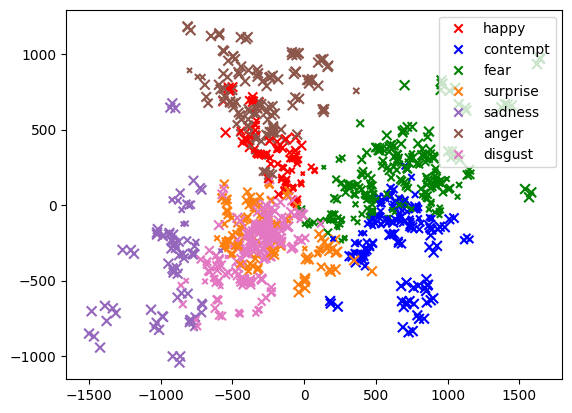

In [317]:
probs = gm_pca.predict_proba(X).round(3)
labels = gm_pca.fit(X).predict(X)
colors = ListedColormap(['r','b','g','tab:orange','tab:purple','tab:brown','tab:pink'])
size = 50 * probs.max(1) ** 2  # square emphasizes differences
types = ["happy","contempt","fear","surprise","sadness","anger","disgust"]
scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, s=size,marker="x",cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=types,loc='upper right')


In [216]:
kmeans = KMeansClustering(X,n_clusters=8)
dbscan = DBSCANClustering(eps=0.5, min_samples=5)
gmm = GMMClustering(n_components=8)


KMeansClustering:  8
GMMClustering:  8


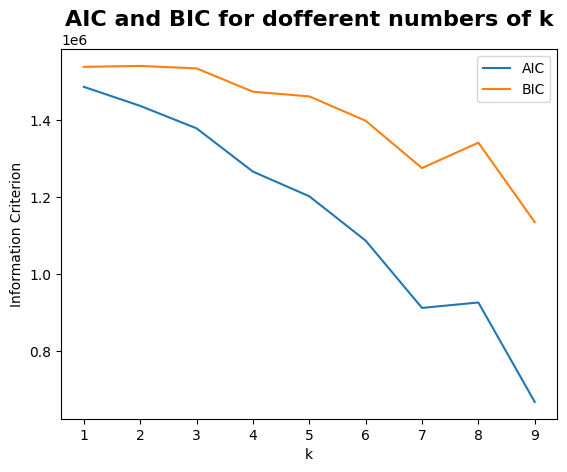

In [ ]:
Sum_bic = []
Sum_aic = []

K = range(1,10)
for k in K:
    gmm = GaussianMixture(n_components=k)
    gmm = gmm.fit(X)
    Sum_bic.append(gmm.bic(X))
    Sum_aic.append(gmm.aic(X))
    x1 = K
y1 = Sum_aic
plt.plot(x1, y1, label = "AIC")
x2 = K
y2 = Sum_bic
plt.plot(x2, y2, label = "BIC")

plt.title("AIC and BIC for different numbers of k", fontsize=16, fontweight='bold')
plt.xlabel("k")
plt.ylabel("Information Criterion")
plt.legend(loc='upper right')
plt.show()